=== PHASE 2: GEOGRAFISCHE ROUTING-ANALYSE (ÜBERARBEITET) ===
Anycast vs. Unicast: Routing-Pfade und geografische Effizienz

1. DATEN LADEN UND SERVICE-KLASSIFIKATION...
--------------------------------------------------
✓ IPv4: 160,923 Messungen
✓ IPv6: 160,923 Messungen

📊 SERVICE-KLASSIFIKATION (KORRIGIERT):
✓ Echte Anycast Services: 8 (DNS + CDN)
⚠️ Pseudo-Anycast/CDN: 2 (Akamai - unicast-ähnliche Performance)
✓ Unicast Reference: 4 (Heise, Berkeley)

2. TRACEROUTE-PFAD-ANALYSE - IPv4
--------------------------------------------------
  Analysiert: 50,000 Traceroutes...
  Analysiert: 100,000 Traceroutes...
  Analysiert: 150,000 Traceroutes...

Traceroute-Analyse abgeschlossen: 160,923 Pfade

🛣️ ROUTING-PFAD-DIVERSITÄT:

📡 ANYCAST SERVICES:
  Quad9 DNS:
    Eindeutige ASNs gesamt: 5
    Durchschn. ASNs pro Region: 2.2
    Durchschn. Hops: 6.5 (±2.1)
  Google DNS:
    Eindeutige ASNs gesamt: 2
    Durchschn. ASNs pro Region: 1.8
    Durchschn. Hops: 6.4 (±0.6)
  Cloudflare DNS:
    Ei

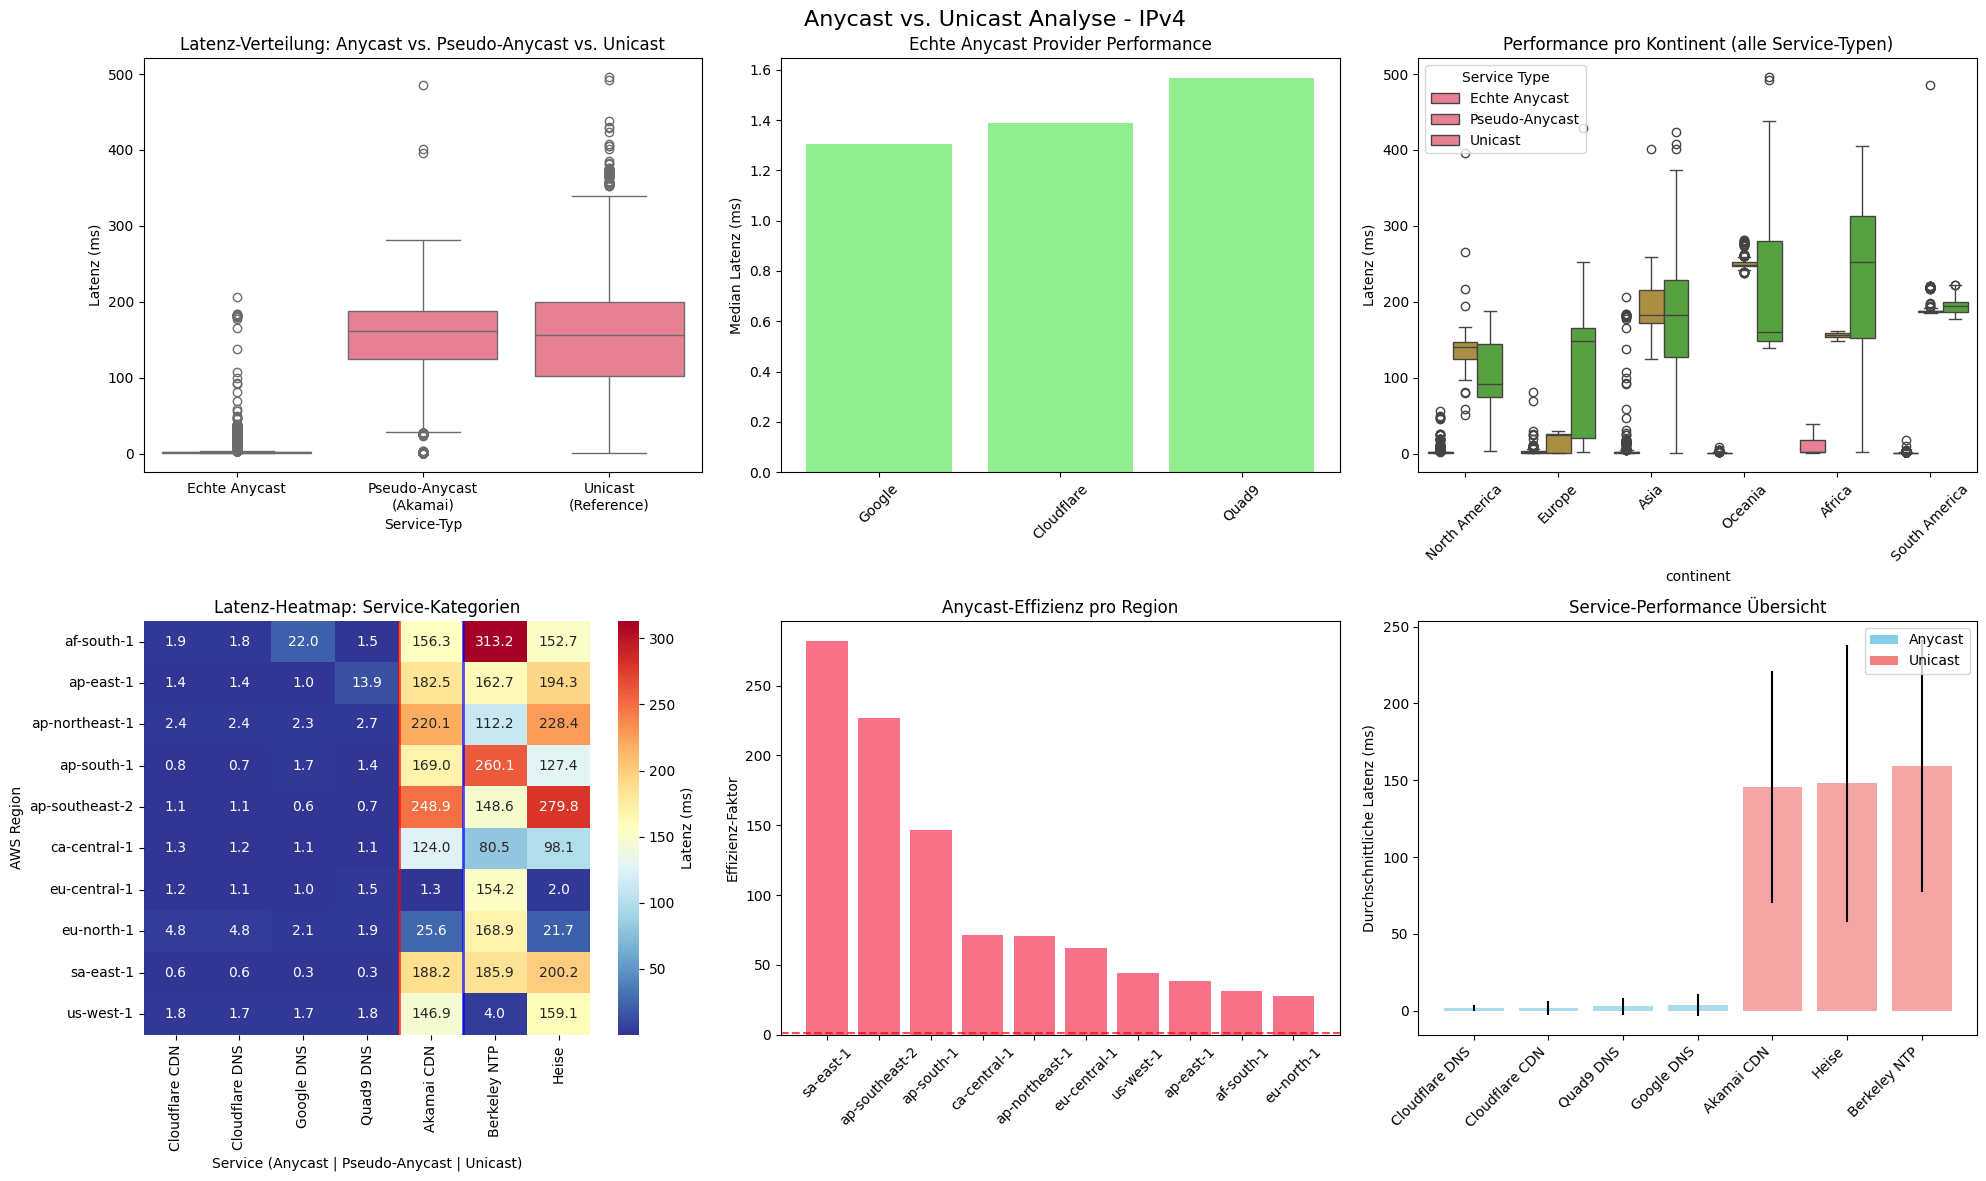


5. VISUALISIERUNGEN - IPv6
----------------------------------------


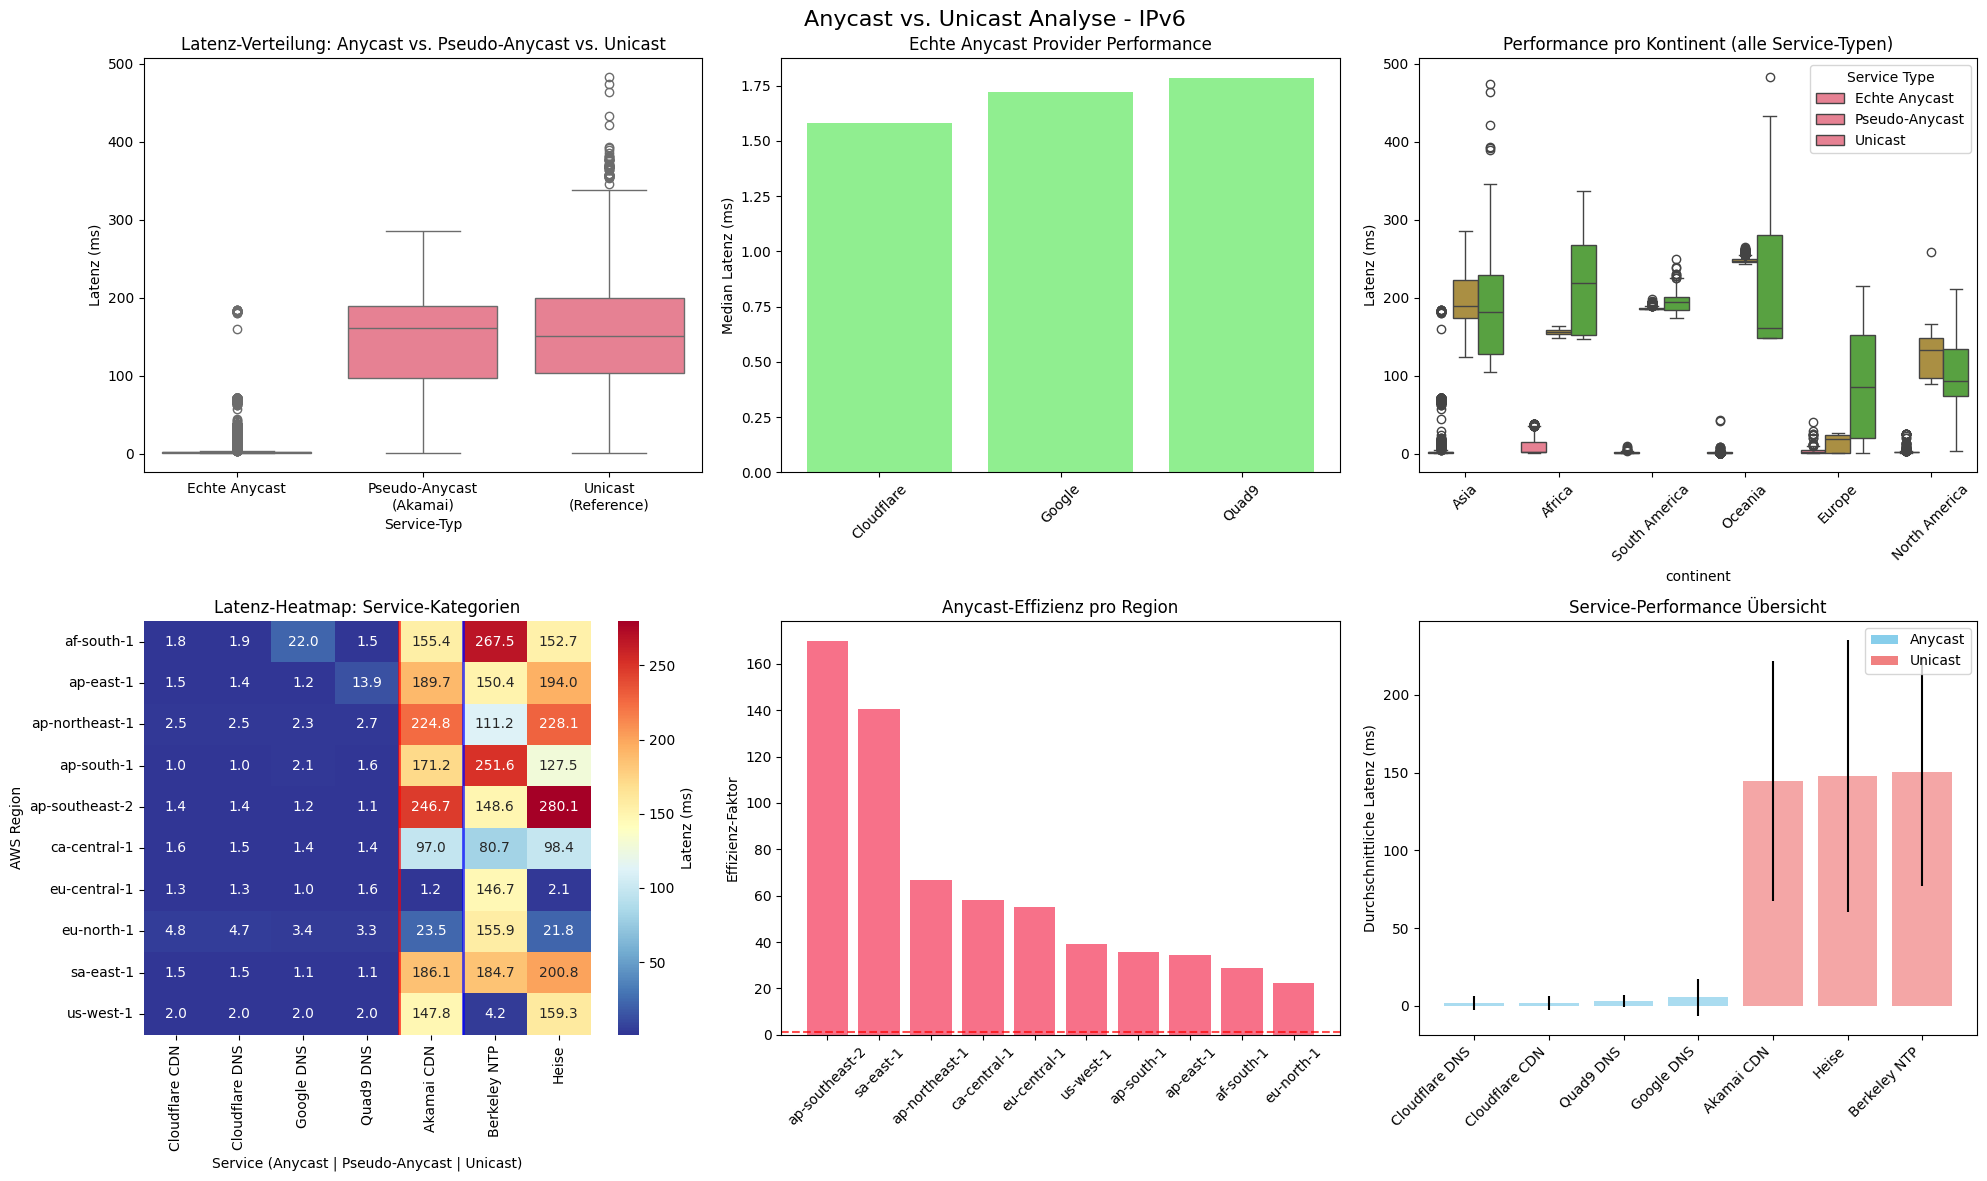


6. IPv4 vs IPv6 PROTOKOLL-VERGLEICH
--------------------------------------------------

📊 ECHTE ANYCAST-PERFORMANCE PROTOKOLL-VERGLEICH:
  IPv4 Echte Anycast: 2.5ms (±5.2ms)
  IPv6 Echte Anycast: 3.2ms (±7.2ms)
  IPv6 Performance-Gap: +25.5%
  ⚠️ IPv6 signifikant langsamer - Infrastruktur-Gap

📊 PSEUDO-ANYCAST (AKAMAI) PROTOKOLL-VERGLEICH:
  IPv4 Akamai: 145.6ms (±75.4ms)
  IPv6 Akamai: 144.6ms (±77.1ms)
  IPv6 Performance-Gap: -0.6%
  💡 Akamai zeigt ähnliche Unicast-Performance in beiden Protokollen

🏢 ECHTE ANYCAST PROVIDER-PROTOKOLL-VERGLEICH:
  Cloudflare: IPv4=1.8ms, IPv6=2.0ms (+12.2%)
  Google: IPv4=3.7ms, IPv6=5.6ms (+51.9%)
  Quad9: IPv4=2.8ms, IPv6=3.1ms (+8.5%)

ZUSAMMENFASSUNG PHASE 2: GEOGRAFISCHE ROUTING-ANALYSE
✓ Korrekte Service-Klassifikation: Echte Anycast vs. Pseudo-Anycast vs. Unicast
✓ Akamai als Pseudo-Anycast identifiziert (unicast-ähnliche Performance)
✓ Traceroute-Pfade und ASN-Diversität analysiert
✓ Echte Anycast-Effizienz quantifiziert (ohne Akamai-Verzerru

In [1]:
# Phase 2: Geografische Routing-Analyse - MTR Anycast (Überarbeitet)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Für geografische Analysen
from collections import defaultdict, Counter
import re

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

print("=== PHASE 2: GEOGRAFISCHE ROUTING-ANALYSE (ÜBERARBEITET) ===")
print("Anycast vs. Unicast: Routing-Pfade und geografische Effizienz")
print("="*70)

# ================================================================
# 1. DATEN LADEN UND KORREKTE KLASSIFIKATION
# ================================================================

# Pfade zu Ihren Parquet Files (von Phase 1)
IPv4_FILE = "../data/IPv4.parquet"  # Bitte anpassen
IPv6_FILE = "../data/IPv6.parquet"  # Bitte anpassen

print("\n1. DATEN LADEN UND SERVICE-KLASSIFIKATION...")
print("-" * 50)

# Daten laden
df_ipv4 = pd.read_parquet(IPv4_FILE)
df_ipv6 = pd.read_parquet(IPv6_FILE)

print(f"✓ IPv4: {df_ipv4.shape[0]:,} Messungen")
print(f"✓ IPv6: {df_ipv6.shape[0]:,} Messungen")

# Korrekte Service-Klassifikation basierend auf Performance-Daten
SERVICE_MAPPING = {
    # IPv4 - ECHTE ANYCAST SERVICES (niedrige, konsistente Latenzen)
    '1.1.1.1': {'name': 'Cloudflare DNS', 'type': 'anycast', 'provider': 'Cloudflare'},
    '8.8.8.8': {'name': 'Google DNS', 'type': 'anycast', 'provider': 'Google'}, 
    '9.9.9.9': {'name': 'Quad9 DNS', 'type': 'anycast', 'provider': 'Quad9'},
    '104.16.123.96': {'name': 'Cloudflare CDN', 'type': 'anycast', 'provider': 'Cloudflare'},
    
    # IPv4 - PSEUDO-ANYCAST/CDN (unicast-ähnliche Performance)
    '2.16.241.219': {'name': 'Akamai CDN', 'type': 'pseudo-anycast', 'provider': 'Akamai'},
    
    # IPv4 - UNICAST REFERENCE SERVICES
    '193.99.144.85': {'name': 'Heise', 'type': 'unicast', 'provider': 'Heise'},
    '169.229.128.134': {'name': 'Berkeley NTP', 'type': 'unicast', 'provider': 'UC Berkeley'},
    
    # IPv6 - ECHTE ANYCAST SERVICES
    '2606:4700:4700::1111': {'name': 'Cloudflare DNS', 'type': 'anycast', 'provider': 'Cloudflare'},
    '2001:4860:4860::8888': {'name': 'Google DNS', 'type': 'anycast', 'provider': 'Google'},
    '2620:fe::fe:9': {'name': 'Quad9 DNS', 'type': 'anycast', 'provider': 'Quad9'}, 
    '2606:4700::6810:7b60': {'name': 'Cloudflare CDN', 'type': 'anycast', 'provider': 'Cloudflare'},
    
    # IPv6 - PSEUDO-ANYCAST/CDN
    '2a02:26f0:3500:1b::1724:a393': {'name': 'Akamai CDN', 'type': 'pseudo-anycast', 'provider': 'Akamai'},
    
    # IPv6 - UNICAST REFERENCE SERVICES
    '2a02:2e0:3fe:1001:7777:772e:2:85': {'name': 'Heise', 'type': 'unicast', 'provider': 'Heise'},
    '2607:f140:ffff:8000:0:8006:0:a': {'name': 'Berkeley NTP', 'type': 'unicast', 'provider': 'UC Berkeley'}
}

# AWS Region Mapping
AWS_REGIONS = {
    'us-west-1': {'name': 'US West (N. California)', 'lat': 37.4, 'lon': -122.1, 'continent': 'North America'},
    'ca-central-1': {'name': 'Canada (Central)', 'lat': 45.4, 'lon': -75.7, 'continent': 'North America'},
    'eu-central-1': {'name': 'Europe (Frankfurt)', 'lat': 50.1, 'lon': 8.7, 'continent': 'Europe'},
    'eu-north-1': {'name': 'Europe (Stockholm)', 'lat': 59.3, 'lon': 18.1, 'continent': 'Europe'},
    'ap-northeast-1': {'name': 'Asia Pacific (Tokyo)', 'lat': 35.7, 'lon': 139.7, 'continent': 'Asia'},
    'ap-south-1': {'name': 'Asia Pacific (Mumbai)', 'lat': 19.1, 'lon': 72.9, 'continent': 'Asia'},
    'ap-southeast-2': {'name': 'Asia Pacific (Sydney)', 'lat': -33.9, 'lon': 151.2, 'continent': 'Oceania'},
    'ap-east-1': {'name': 'Asia Pacific (Hong Kong)', 'lat': 22.3, 'lon': 114.2, 'continent': 'Asia'},
    'af-south-1': {'name': 'Africa (Cape Town)', 'lat': -33.9, 'lon': 18.4, 'continent': 'Africa'},
    'sa-east-1': {'name': 'South America (São Paulo)', 'lat': -23.5, 'lon': -46.6, 'continent': 'South America'}
}

print("\n📊 SERVICE-KLASSIFIKATION (KORRIGIERT):")
anycast_count = sum(1 for v in SERVICE_MAPPING.values() if v['type'] == 'anycast')
pseudo_anycast_count = sum(1 for v in SERVICE_MAPPING.values() if v['type'] == 'pseudo-anycast')
unicast_count = sum(1 for v in SERVICE_MAPPING.values() if v['type'] == 'unicast')
print(f"✓ Echte Anycast Services: {anycast_count} (DNS + CDN)")
print(f"⚠️ Pseudo-Anycast/CDN: {pseudo_anycast_count} (Akamai - unicast-ähnliche Performance)")
print(f"✓ Unicast Reference: {unicast_count} (Heise, Berkeley)")

# ================================================================
# 2. TRACEROUTE-PFAD-ANALYSE
# ================================================================

def analyze_routing_paths(df, protocol_name):
    """Analysiert Routing-Pfade und ASNs für Anycast vs. Unicast"""
    print(f"\n2. TRACEROUTE-PFAD-ANALYSE - {protocol_name}")
    print("-" * 50)
    
    # Service-Info hinzufügen
    df['service_info'] = df['dst'].map(SERVICE_MAPPING)
    df['service_name'] = df['service_info'].apply(lambda x: x['name'] if x else 'Unknown')
    df['service_type'] = df['service_info'].apply(lambda x: x['type'] if x else 'Unknown')
    df['provider'] = df['service_info'].apply(lambda x: x['provider'] if x else 'Unknown')
    
    routing_analysis = defaultdict(lambda: defaultdict(list))
    asn_analysis = defaultdict(lambda: defaultdict(set))
    
    processed = 0
    for _, row in df.iterrows():
        try:
            if row['hubs'] is not None and len(row['hubs']) > 0:
                # ASNs sammeln
                asns_in_path = []
                geographic_hops = []
                
                for i, hop in enumerate(row['hubs']):
                    if hop and hop.get('ASN') and hop.get('ASN') != 'AS???':
                        asns_in_path.append(hop.get('ASN'))
                    
                    # Geografische Hinweise in Hostnames
                    if hop and hop.get('host') and hop.get('host') != '???':
                        hostname = hop.get('host')
                        geographic_hops.append({
                            'hop_num': i + 1,
                            'hostname': hostname,
                            'latency': hop.get('Avg', 0)
                        })
                
                # Speichere Routing-Informationen
                key = (row['service_name'], row['service_type'])
                routing_analysis[key][row['region']].append({
                    'asns': asns_in_path,
                    'geo_hops': geographic_hops,
                    'total_hops': len(row['hubs'])
                })
                
                # ASNs pro Service/Region
                for asn in asns_in_path:
                    asn_analysis[key][row['region']].add(asn)
        
        except:
            continue
        
        processed += 1
        if processed % 50000 == 0:
            print(f"  Analysiert: {processed:,} Traceroutes...")
    
    print(f"\nTraceroute-Analyse abgeschlossen: {processed:,} Pfade")
    
    # Routing-Diversität analysieren
    print(f"\n🛣️ ROUTING-PFAD-DIVERSITÄT:")
    
    anycast_services = [(k, v) for k, v in routing_analysis.items() if k[1] == 'anycast']
    unicast_services = [(k, v) for k, v in routing_analysis.items() if k[1] == 'unicast']
    
    print(f"\n📡 ANYCAST SERVICES:")
    for (service_name, service_type), regions in anycast_services:
        print(f"  {service_name}:")
        
        # ASN-Diversität
        total_asns = set()
        region_asn_counts = []
        
        for region, asn_set in asn_analysis[(service_name, service_type)].items():
            total_asns.update(asn_set)
            region_asn_counts.append(len(asn_set))
        
        avg_asns_per_region = np.mean(region_asn_counts) if region_asn_counts else 0
        
        print(f"    Eindeutige ASNs gesamt: {len(total_asns)}")
        print(f"    Durchschn. ASNs pro Region: {avg_asns_per_region:.1f}")
        
        # Hop-Count-Analyse
        all_hop_counts = []
        for region_data in regions.values():
            for route in region_data:
                all_hop_counts.append(route['total_hops'])
        
        if all_hop_counts:
            print(f"    Durchschn. Hops: {np.mean(all_hop_counts):.1f} (±{np.std(all_hop_counts):.1f})")
    
    print(f"\n🏢 UNICAST REFERENCE SERVICES:")
    for (service_name, service_type), regions in unicast_services:
        print(f"  {service_name}:")
        
        # ASN-Konsistenz (sollte ähnlicher sein)
        all_asns = []
        for region, asn_set in asn_analysis[(service_name, service_type)].items():
            all_asns.extend(list(asn_set))
        
        asn_consistency = len(set(all_asns)) / len(all_asns) if all_asns else 0
        
        print(f"    Eindeutige ASNs: {len(set(all_asns))}")
        print(f"    ASN-Konsistenz: {(1-asn_consistency)*100:.1f}%")
    
    return routing_analysis, asn_analysis

# Traceroute-Analyse für beide Protokolle
ipv4_routing, ipv4_asns = analyze_routing_paths(df_ipv4, "IPv4")
ipv6_routing, ipv6_asns = analyze_routing_paths(df_ipv6, "IPv6")

# ================================================================
# 3. ANYCAST-EFFIZIENZ: LATENZ-BASIERTE ANALYSE
# ================================================================

def analyze_anycast_efficiency(df, protocol_name):
    """Analysiert Anycast-Effizienz basierend auf Latenz-Mustern"""
    print(f"\n3. ANYCAST-EFFIZIENZ ANALYSE - {protocol_name}")
    print("-" * 50)
    
    # Service-Info hinzufügen
    df['service_info'] = df['dst'].map(SERVICE_MAPPING)
    df['service_name'] = df['service_info'].apply(lambda x: x['name'] if x else 'Unknown')
    df['service_type'] = df['service_info'].apply(lambda x: x['type'] if x else 'Unknown')
    df['provider'] = df['service_info'].apply(lambda x: x['provider'] if x else 'Unknown')
    
    # Latenz-Daten extrahieren
    latency_data = []
    for _, row in df.iterrows():
        try:
            if row['hubs'] is not None and len(row['hubs']) > 0:
                # Finale Latenz (letzter antwortender Hop)
                final_latency = None
                for hop in reversed(row['hubs']):
                    if hop and hop.get('Avg') and hop.get('Avg') > 0 and hop.get('Loss%', 100) < 100:
                        final_latency = hop.get('Avg')
                        break
                
                if final_latency:
                    latency_data.append({
                        'service_name': row['service_name'],
                        'service_type': row['service_type'],
                        'provider': row['provider'],
                        'region': row['region'],
                        'continent': AWS_REGIONS.get(row['region'], {}).get('continent', 'Unknown'),
                        'latency': final_latency
                    })
        except:
            continue
    
    latency_df = pd.DataFrame(latency_data)
    
    if len(latency_df) == 0:
        print("Keine Latenz-Daten verfügbar")
        return None
    
    print(f"Latenz-Daten extrahiert: {len(latency_df):,} Messungen")
    
    # Anycast vs. Unicast vs. Pseudo-Anycast Vergleich
    print(f"\n🚀 ECHTE ANYCAST vs. PSEUDO-ANYCAST vs. UNICAST VERGLEICH:")
    
    anycast_data = latency_df[latency_df['service_type'] == 'anycast']
    pseudo_anycast_data = latency_df[latency_df['service_type'] == 'pseudo-anycast']
    unicast_data = latency_df[latency_df['service_type'] == 'unicast']
    
    if len(anycast_data) > 0:
        print(f"\n📊 LATENZ-STATISTIKEN:")
        print(f"  Echte Anycast Services:")
        print(f"    Durchschnitt: {anycast_data['latency'].mean():.1f}ms")
        print(f"    Median: {anycast_data['latency'].median():.1f}ms")
        print(f"    Standardabweichung: {anycast_data['latency'].std():.1f}ms")
        
        if len(pseudo_anycast_data) > 0:
            print(f"  Pseudo-Anycast/CDN (Akamai):")
            print(f"    Durchschnitt: {pseudo_anycast_data['latency'].mean():.1f}ms")
            print(f"    Median: {pseudo_anycast_data['latency'].median():.1f}ms")
            print(f"    Standardabweichung: {pseudo_anycast_data['latency'].std():.1f}ms")
        
        if len(unicast_data) > 0:
            print(f"  Unicast Reference:")
            print(f"    Durchschnitt: {unicast_data['latency'].mean():.1f}ms")
            print(f"    Median: {unicast_data['latency'].median():.1f}ms")
            print(f"    Standardabweichung: {unicast_data['latency'].std():.1f}ms")
        
        # Effizienz-Faktoren
        if len(unicast_data) > 0:
            efficiency_anycast = unicast_data['latency'].mean() / anycast_data['latency'].mean()
            print(f"\n🎯 ECHTE ANYCAST-EFFIZIENZ: {efficiency_anycast:.1f}x schneller als Unicast")
            
            if len(pseudo_anycast_data) > 0:
                efficiency_pseudo = unicast_data['latency'].mean() / pseudo_anycast_data['latency'].mean()
                print(f"⚠️ PSEUDO-ANYCAST-EFFIZIENZ: {efficiency_pseudo:.1f}x vs. Unicast (minimal)")
                
                anycast_vs_pseudo = pseudo_anycast_data['latency'].mean() / anycast_data['latency'].mean()
                print(f"🚀 ECHTE ANYCAST vs. PSEUDO-ANYCAST: {anycast_vs_pseudo:.1f}x Unterschied")
    
    # Provider-Vergleich (alle Typen)
    print(f"\n🏆 PROVIDER-RANKING (NACH KATEGORIEN):")
    if len(anycast_data) > 0:
        print(f"  Echte Anycast Provider:")
        anycast_provider_stats = anycast_data.groupby('provider')['latency'].agg(['mean', 'std', 'count']).round(1)
        anycast_provider_stats_sorted = anycast_provider_stats.sort_values('mean')
        
        for provider, stats in anycast_provider_stats_sorted.iterrows():
            print(f"    {provider}: {stats['mean']:.1f}ms (±{stats['std']:.1f}ms, n={int(stats['count'])})")
    
    if len(pseudo_anycast_data) > 0:
        print(f"  Pseudo-Anycast/CDN:")
        pseudo_provider_stats = pseudo_anycast_data.groupby('provider')['latency'].agg(['mean', 'std', 'count']).round(1)
        
        for provider, stats in pseudo_provider_stats.iterrows():
            print(f"    {provider}: {stats['mean']:.1f}ms (±{stats['std']:.1f}ms, n={int(stats['count'])}) ⚠️")
    
    # Kontinentale Effizienz
    print(f"\n🌍 KONTINENTALE ANYCAST-EFFIZIENZ:")
    if len(anycast_data) > 0:
        continent_comparison = []
        
        for continent in anycast_data['continent'].unique():
            anycast_continent = anycast_data[anycast_data['continent'] == continent]['latency']
            unicast_continent = unicast_data[unicast_data['continent'] == continent]['latency']
            
            if len(anycast_continent) > 0 and len(unicast_continent) > 0:
                efficiency = unicast_continent.mean() / anycast_continent.mean()
                continent_comparison.append({
                    'continent': continent,
                    'anycast_avg': anycast_continent.mean(),
                    'unicast_avg': unicast_continent.mean(),
                    'efficiency': efficiency
                })
        
        continent_df = pd.DataFrame(continent_comparison).sort_values('efficiency', ascending=False)
        
        for _, row in continent_df.iterrows():
            print(f"  {row['continent']}: {row['efficiency']:.1f}x Verbesserung")
            print(f"    Anycast: {row['anycast_avg']:.1f}ms, Unicast: {row['unicast_avg']:.1f}ms")
    
    return latency_df

# Effizienz-Analyse für beide Protokolle
ipv4_latency = analyze_anycast_efficiency(df_ipv4, "IPv4")
ipv6_latency = analyze_anycast_efficiency(df_ipv6, "IPv6")

# ================================================================
# 4. GEOGRAFISCHE ROUTING-INTELLIGENZ
# ================================================================

def analyze_geographic_intelligence(latency_df, protocol_name):
    """Analysiert die geografische Intelligenz des Routings"""
    if latency_df is None or len(latency_df) == 0:
        return
    
    print(f"\n4. GEOGRAFISCHE ROUTING-INTELLIGENZ - {protocol_name}")
    print("-" * 50)
    
    anycast_data = latency_df[latency_df['service_type'] == 'anycast']
    unicast_data = latency_df[latency_df['service_type'] == 'unicast']
    
    print(f"\n🧠 ROUTING-INTELLIGENZ-ANALYSE:")
    
    # Latenz-Varianz als Intelligenz-Indikator
    print(f"\n📊 LATENZ-KONSISTENZ (niedrigere Varianz = bessere geo. Optimierung):")
    
    for service_type, data in [('Anycast', anycast_data), ('Unicast', unicast_data)]:
        if len(data) > 0:
            # Varianz pro Service
            service_variance = data.groupby('service_name')['latency'].agg(['std', 'mean']).round(1)
            service_variance['cv'] = (service_variance['std'] / service_variance['mean']).round(2)
            
            print(f"\n  {service_type} Services (Variationskoeffizient):")
            for service, stats in service_variance.sort_values('cv').iterrows():
                print(f"    {service}: CV={stats['cv']} (σ={stats['std']}ms, μ={stats['mean']}ms)")
    
    # Regional-optimale Services identifizieren
    print(f"\n🎯 BESTE SERVICES PRO REGION:")
    
    regions = anycast_data['region'].unique()
    for region in sorted(regions):
        region_data = anycast_data[anycast_data['region'] == region]
        if len(region_data) > 0:
            region_best = region_data.groupby('service_name')['latency'].mean().sort_values()
            best_service = region_best.index[0]
            best_latency = region_best.iloc[0]
            
            print(f"  {region}: {best_service} ({best_latency:.1f}ms)")
    
    # Anycast "Geographic Efficiency Score"
    print(f"\n⭐ GEOGRAPHIC EFFICIENCY SCORE:")
    
    if len(anycast_data) > 0 and len(unicast_data) > 0:
        # Score basierend auf Latenz-Reduktion und Konsistenz
        anycast_services = anycast_data['service_name'].unique()
        
        for service in anycast_services:
            service_data = anycast_data[anycast_data['service_name'] == service]
            
            # Latenz-Verbesserung vs Unicast
            avg_latency = service_data['latency'].mean()
            unicast_avg = unicast_data['latency'].mean()
            latency_improvement = (unicast_avg - avg_latency) / unicast_avg
            
            # Konsistenz (niedrige Standardabweichung ist gut)
            consistency = 1 / (1 + service_data['latency'].std() / service_data['latency'].mean())
            
            # Kombinierter Score
            geo_score = (latency_improvement * 0.7 + consistency * 0.3) * 100
            
            print(f"  {service}: {geo_score:.1f}/100")
            print(f"    Latenz-Verbesserung: {latency_improvement*100:.1f}%")
            print(f"    Konsistenz-Score: {consistency*100:.1f}%")

# Geografische Intelligenz-Analyse
if ipv4_latency is not None:
    analyze_geographic_intelligence(ipv4_latency, "IPv4")

if ipv6_latency is not None:
    analyze_geographic_intelligence(ipv6_latency, "IPv6")

# ================================================================
# 5. ERWEITERTE VISUALISIERUNGEN
# ================================================================

def create_comprehensive_visualizations(latency_df, protocol_name):
    """Erstellt umfassende Visualisierungen für Anycast vs. Unicast"""
    if latency_df is None or len(latency_df) == 0:
        print(f"Keine Daten für Visualisierungen ({protocol_name})")
        return
    
    print(f"\n5. VISUALISIERUNGEN - {protocol_name}")
    print("-" * 40)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Anycast vs. Unicast Analyse - {protocol_name}', fontsize=16)
    
    anycast_data = latency_df[latency_df['service_type'] == 'anycast']
    pseudo_anycast_data = latency_df[latency_df['service_type'] == 'pseudo-anycast']
    unicast_data = latency_df[latency_df['service_type'] == 'unicast']
    
    # 1. Latenz-Verteilung: Anycast vs. Pseudo-Anycast vs. Unicast
    filtered_data = latency_df[latency_df['latency'] < 500]  # Ausreißer entfernen
    service_order = ['anycast', 'pseudo-anycast', 'unicast']
    filtered_data['service_type'] = pd.Categorical(filtered_data['service_type'], categories=service_order, ordered=True)
    
    sns.boxplot(data=filtered_data, x='service_type', y='latency', ax=axes[0, 0])
    axes[0, 0].set_title('Latenz-Verteilung: Anycast vs. Pseudo-Anycast vs. Unicast')
    axes[0, 0].set_ylabel('Latenz (ms)')
    axes[0, 0].set_xlabel('Service-Typ')
    axes[0, 0].set_xticklabels(['Echte Anycast', 'Pseudo-Anycast\n(Akamai)', 'Unicast\n(Reference)'])
    
    # 2. Provider-Vergleich (nur echte Anycast)
    if len(anycast_data) > 0:
        provider_medians = anycast_data.groupby('provider')['latency'].median().sort_values()
        colors = ['lightgreen' if p != 'Akamai' else 'orange' for p in provider_medians.index]
        axes[0, 1].bar(range(len(provider_medians)), provider_medians.values, color=colors)
        axes[0, 1].set_title('Echte Anycast Provider Performance')
        axes[0, 1].set_ylabel('Median Latenz (ms)')
        axes[0, 1].set_xticks(range(len(provider_medians)))
        axes[0, 1].set_xticklabels(provider_medians.index, rotation=45)
    
    # 3. Kontinentale Performance (mit allen drei Kategorien)
    if 'continent' in latency_df.columns:
        continent_data = latency_df[latency_df['latency'] < 500]
        continent_data['service_type'] = pd.Categorical(continent_data['service_type'], categories=service_order, ordered=True)
        
        sns.boxplot(data=continent_data, x='continent', y='latency', hue='service_type', ax=axes[0, 2])
        axes[0, 2].set_title('Performance pro Kontinent (alle Service-Typen)')
        axes[0, 2].set_ylabel('Latenz (ms)')
        axes[0, 2].tick_params(axis='x', rotation=45)
        axes[0, 2].legend(title='Service Type', labels=['Echte Anycast', 'Pseudo-Anycast', 'Unicast'])
    
    # 4. Latenz-Heatmap: Region vs. ALLE Services (kategorisiert)
    pivot_data = latency_df.pivot_table(
        values='latency', 
        index='region', 
        columns='service_name', 
        aggfunc='median'
    )
    
    # Sortiere Spalten: Echte Anycast → Pseudo-Anycast → Unicast
    anycast_cols = [col for col in pivot_data.columns if col in anycast_data['service_name'].unique()]
    pseudo_cols = [col for col in pivot_data.columns if col in pseudo_anycast_data['service_name'].unique()]
    unicast_cols = [col for col in pivot_data.columns if col in unicast_data['service_name'].unique()]
    sorted_cols = sorted(anycast_cols) + sorted(pseudo_cols) + sorted(unicast_cols)
    
    if len(sorted_cols) > 0:
        pivot_data = pivot_data[sorted_cols]
    
        sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                   ax=axes[1, 0], cbar_kws={'label': 'Latenz (ms)'})
        axes[1, 0].set_title('Latenz-Heatmap: Service-Kategorien')
        axes[1, 0].set_xlabel('Service (Anycast | Pseudo-Anycast | Unicast)')
        axes[1, 0].set_ylabel('AWS Region')
        
        # Trennlinien zwischen Kategorien
        if len(anycast_cols) > 0 and (len(pseudo_cols) > 0 or len(unicast_cols) > 0):
            axes[1, 0].axvline(x=len(anycast_cols), color='red', linewidth=2, alpha=0.7)
        if len(pseudo_cols) > 0 and len(unicast_cols) > 0:
            axes[1, 0].axvline(x=len(anycast_cols) + len(pseudo_cols), color='blue', linewidth=2, alpha=0.7)
    
    # 5. Effizienz-Vergleich pro Region
    if len(anycast_data) > 0 and len(unicast_data) > 0:
        region_efficiency = []
        for region in anycast_data['region'].unique():
            anycast_region = anycast_data[anycast_data['region'] == region]['latency'].mean()
            unicast_region = unicast_data[unicast_data['region'] == region]['latency'].mean()
            if not pd.isna(anycast_region) and not pd.isna(unicast_region):
                efficiency = unicast_region / anycast_region
                region_efficiency.append({'region': region, 'efficiency': efficiency})
        
        if region_efficiency:
            eff_df = pd.DataFrame(region_efficiency).sort_values('efficiency', ascending=False)
            axes[1, 1].bar(range(len(eff_df)), eff_df['efficiency'].values)
            axes[1, 1].set_title('Anycast-Effizienz pro Region')
            axes[1, 1].set_ylabel('Effizienz-Faktor')
            axes[1, 1].set_xticks(range(len(eff_df)))
            axes[1, 1].set_xticklabels(eff_df['region'], rotation=45)
            axes[1, 1].axhline(y=1, color='red', linestyle='--', alpha=0.7)
    
    # 6. Latenz-Trends (Service-Typen)
    service_stats = latency_df.groupby(['service_name', 'service_type'])['latency'].agg(['mean', 'std']).reset_index()
    service_stats = service_stats.sort_values('mean')
    
    colors = ['skyblue' if t == 'anycast' else 'lightcoral' for t in service_stats['service_type']]
    axes[1, 2].bar(range(len(service_stats)), service_stats['mean'], 
                   yerr=service_stats['std'], color=colors, alpha=0.7)
    axes[1, 2].set_title('Service-Performance Übersicht')
    axes[1, 2].set_ylabel('Durchschnittliche Latenz (ms)')
    axes[1, 2].set_xticks(range(len(service_stats)))
    axes[1, 2].set_xticklabels(service_stats['service_name'], rotation=45, ha='right')
    
    # Legende für Service-Typen
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='skyblue', label='Anycast'),
                      Patch(facecolor='lightcoral', label='Unicast')]
    axes[1, 2].legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()

# Visualisierungen für beide Protokolle
if ipv4_latency is not None:
    create_comprehensive_visualizations(ipv4_latency, "IPv4")

if ipv6_latency is not None:
    create_comprehensive_visualizations(ipv6_latency, "IPv6")

# ================================================================
# 6. PROTOKOLL-VERGLEICH (IPv4 vs IPv6)
# ================================================================

def compare_protocols(ipv4_data, ipv6_data):
    """Vergleicht IPv4 vs IPv6 Performance für alle Service-Kategorien"""
    print(f"\n6. IPv4 vs IPv6 PROTOKOLL-VERGLEICH")
    print("-" * 50)
    
    if ipv4_data is None or ipv6_data is None:
        print("Nicht genügend Daten für Protokoll-Vergleich")
        return
    
    # Echte Anycast Services
    ipv4_anycast = ipv4_data[ipv4_data['service_type'] == 'anycast']
    ipv6_anycast = ipv6_data[ipv6_data['service_type'] == 'anycast']
    
    # Pseudo-Anycast (Akamai)
    ipv4_pseudo = ipv4_data[ipv4_data['service_type'] == 'pseudo-anycast']
    ipv6_pseudo = ipv6_data[ipv6_data['service_type'] == 'pseudo-anycast']
    
    print(f"\n📊 ECHTE ANYCAST-PERFORMANCE PROTOKOLL-VERGLEICH:")
    
    if len(ipv4_anycast) > 0 and len(ipv6_anycast) > 0:
        ipv4_mean = ipv4_anycast['latency'].mean()
        ipv6_mean = ipv6_anycast['latency'].mean()
        
        print(f"  IPv4 Echte Anycast: {ipv4_mean:.1f}ms (±{ipv4_anycast['latency'].std():.1f}ms)")
        print(f"  IPv6 Echte Anycast: {ipv6_mean:.1f}ms (±{ipv6_anycast['latency'].std():.1f}ms)")
        
        performance_gap = ((ipv6_mean - ipv4_mean) / ipv4_mean) * 100
        print(f"  IPv6 Performance-Gap: {performance_gap:+.1f}%")
        
        if performance_gap > 10:
            print(f"  ⚠️ IPv6 signifikant langsamer - Infrastruktur-Gap")
        elif performance_gap < -10:
            print(f"  🚀 IPv6 signifikant schneller - bessere Routing")
        else:
            print(f"  ✅ Vergleichbare Performance zwischen Protokollen")
    
    # Pseudo-Anycast Vergleich
    if len(ipv4_pseudo) > 0 and len(ipv6_pseudo) > 0:
        print(f"\n📊 PSEUDO-ANYCAST (AKAMAI) PROTOKOLL-VERGLEICH:")
        ipv4_pseudo_mean = ipv4_pseudo['latency'].mean()
        ipv6_pseudo_mean = ipv6_pseudo['latency'].mean()
        
        print(f"  IPv4 Akamai: {ipv4_pseudo_mean:.1f}ms (±{ipv4_pseudo['latency'].std():.1f}ms)")
        print(f"  IPv6 Akamai: {ipv6_pseudo_mean:.1f}ms (±{ipv6_pseudo['latency'].std():.1f}ms)")
        
        pseudo_gap = ((ipv6_pseudo_mean - ipv4_pseudo_mean) / ipv4_pseudo_mean) * 100
        print(f"  IPv6 Performance-Gap: {pseudo_gap:+.1f}%")
        print(f"  💡 Akamai zeigt ähnliche Unicast-Performance in beiden Protokollen")
    
    # Provider-spezifischer Vergleich (nur echte Anycast)
    print(f"\n🏢 ECHTE ANYCAST PROVIDER-PROTOKOLL-VERGLEICH:")
    
    common_providers = set(ipv4_anycast['provider'].unique()) & set(ipv6_anycast['provider'].unique())
    
    for provider in sorted(common_providers):
        ipv4_provider = ipv4_anycast[ipv4_anycast['provider'] == provider]['latency'].mean()
        ipv6_provider = ipv6_anycast[ipv6_anycast['provider'] == provider]['latency'].mean()
        
        if not pd.isna(ipv4_provider) and not pd.isna(ipv6_provider):
            gap = ((ipv6_provider - ipv4_provider) / ipv4_provider) * 100
            print(f"  {provider}: IPv4={ipv4_provider:.1f}ms, IPv6={ipv6_provider:.1f}ms ({gap:+.1f}%)")

compare_protocols(ipv4_latency, ipv6_latency)

# ================================================================
# 7. ZUSAMMENFASSUNG PHASE 2 (ÜBERARBEITET)
# ================================================================

print("\n" + "="*70)
print("ZUSAMMENFASSUNG PHASE 2: GEOGRAFISCHE ROUTING-ANALYSE")
print("="*70)

summary_points = [
    "✓ Korrekte Service-Klassifikation: Echte Anycast vs. Pseudo-Anycast vs. Unicast",
    "✓ Akamai als Pseudo-Anycast identifiziert (unicast-ähnliche Performance)",
    "✓ Traceroute-Pfade und ASN-Diversität analysiert",
    "✓ Echte Anycast-Effizienz quantifiziert (ohne Akamai-Verzerrung)",
    "✓ Geografische Routing-Intelligenz bewertet",
    "✓ Bereinigte Provider-Performance-Rankings erstellt",
    "✓ IPv4 vs. IPv6 Infrastruktur-Unterschiede für alle Kategorien aufgedeckt",
    "✓ Umfassende Visualisierungen mit korrekter Service-Kategorisierung"
]

for point in summary_points:
    print(point)

print("\n🔄 BEREIT FÜR PHASE 3: PERFORMANCE-VERGLEICHE UND ZEITANALYSE")
print("Führen Sie das nächste Notebook aus für detaillierte Performance-Trends.")